In [4]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model = spacy.load("en_core_web_trf")

c:\users\mathias\appdata\local\programs\python\python36\lib\site-packages\packaging\version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


In [5]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset_tokenized.pkl")
data.head()

,Contract,Title,Type of contract,Short description,Total value,Place of performance,Contractor,Short description tokenized
0,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger transfer services by bu...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,provision passenger transfer service bus greec...
1,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger services by bus in Gree...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,provision passenger service bus greece chios i...
2,000007-2017,Framework contract for the provision of passen...,SERVICES,Framework contract for the provision of passen...,NaN,GR,None,framework contract provision passenger transfe...
3,008449-2018,Provision of HID® FARGO® HDP5000 ID card print...,SUPPLIES,The subject of the contract is provision of HI...,190000.0,PL,[Control system FMN Sp z oo],subject contract provision hid ® fargo ® hdp50...
4,008450-2018,Provision of painting services for Frontex,SERVICES,Provision of painting services for Frontex.,NaN,PL,None,provision painting service frontex


## Tokenization

In [22]:
def tokenize(sample):
    if not sample:
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS:
                tokens.append(token_processed)        
    return " ".join(tokens)

In [28]:
# test tokenization
sample = data.sample()["Short description"].iloc[0]
print(sample)
print()
print(tokenize(sample))

Supply of handheld thermal cameras.

supply handheld thermal camera


In [25]:
# add a new column to the dataset, namely the tokenized versions of the short description
data["Short description tokenized"] = data["Short description"].apply(tokenize)
data.to_pickle(DATA_PATH + "/processed/dataset_tokenized.pkl")

## Preprocess data

In [63]:
# filter datapoints with invalid or missing descriptions
descriptions = data[data["Short description tokenized"].notna()]
tokenized_descriptions = descriptions["Short description tokenized"]

# vectorize data, that is create matrix of word count per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(tokenized_descriptions)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

In [93]:
# DELETE THIS
# Save visualisation as html for multiple k's
# for i in range(2, 11):
#     lda = LatentDirichletAllocation(n_components=i, learning_method='online')
#     data_lda = lda.fit_transform(data_vectorized)

#     # apparantly this is bugged in jupyterlab, but works in jupyter notebook
#     plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')

#     # export the graph as html
#     pyLDAvis.save_html(plot, VIS_PATH + '/lda_' + str(i) + '_topics.html')

## Find optimal hyperparameters

In [16]:
log_likelihoods = []
perplexities = []
coherences = []
ks = list(range(2, 50))
for i in ks:
    lda = LatentDirichletAllocation(n_components=i, learning_method='online')
    data_lda = lda.fit_transform(data_vectorized)
    
    coherence = metric_coherence_gensim(
        measure='u_mass',
        topic_word_distrib=lda.components_,
        dtm=data_vectorized.toarray(),
        vocab=np.array(vectorizer.get_feature_names())
    )
    coherences.append(np.mean(coherence))
    
    log_likelihoods.append(lda.score(data_vectorized))
    perplexities.append(lda.perplexity(data_vectorized))

3 highest log likelihoods: [-54970.37885831 -55643.18089363 -55758.90907504]
Associated k's: [12, 11, 9]


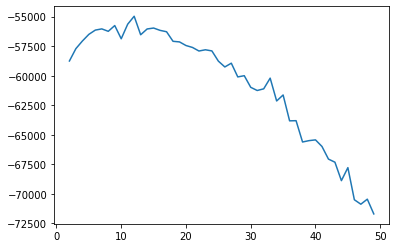

In [17]:
plt.plot(ks, log_likelihoods)

top_n = 3
print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [365.5032751  392.87953893 397.79106302]
Associated k's: [12, 11, 9]


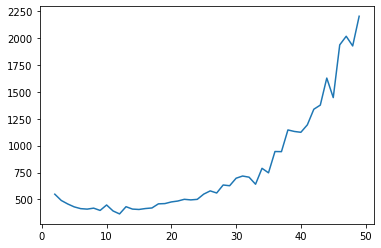

In [18]:
plt.plot(ks, perplexities)

top_n = 3
print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

3 highest cv coherence: [-2.59054285 -3.85326053 -4.86677231]
Associated k's: [2, 4, 7]


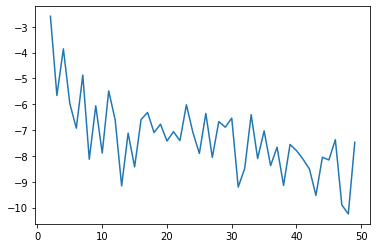

In [19]:
plt.plot(ks, coherences)

top_n = 3
print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [336]:
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=10, learning_method='online')
lda.fit(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [352]:
# transform data
data_lda = lda.transform(data_vectorized)

#### Save model

In [338]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA10.pkl", "wb") as f:
    pickle.dump(lda, f)

#### Load model

In [351]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA11.pkl", "rb") as f:
    lda = pickle.load(f)

## Visualize topics

In [365]:
for t in plot.sorted_terms(topic=11, _lambda=0.6)['Term'][:30].tolist():
    print(t)

surveillance
frontex
define
level
provide
flight
specific
equipment
area
contractor
fwc
eu
aerial
category
land
object
designate
external
interest
report
border
maritime
coordination
centre
course
event
frame
lot
shall
tender


In [353]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False, )

# export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/scikitLDA7_plot.html')

# show plot
plot

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -265.475952   -9.127179       1        1   8.339330
1      110.090302  -87.668854       2        1   2.661257
2       46.032036  268.822968       3        1   3.443039
3      200.820267 -272.470612       4        1   1.159185
4      -11.429106 -302.753693       5        1   3.983222
5      315.308472  -66.648613       6        1   5.430683
6     -230.336487 -240.773102       7        1  20.234562
7       -4.445821   70.211288       8        1   8.184981
8     -174.562256  184.700562       9        1  18.853011
9      -81.438332 -102.793037      10        1   2.382314
10     209.248795  121.076393      11        1  25.328416, topic_info=              Term        Freq       Total Category  logprob  loglift
1036       service  286.000000  286.000000  Default  30.0000  30.0000
1062      software  102.000000  102.000000  Default  29.0000  29.0000
1124        system  115.000000  115.000000  Default  28.0000  28.0000
1119  surveillance   93.000000   93.000000  Default  27.0000  27.0000
485        frontex  208.000000  208.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
765      objective   19.779350   26.622376  Topic11  -4.7815   1.0761
671            lot   30.755248   62.151336  Topic11  -4.3401   0.6697
1040         shall   34.901692   86.984602  Topic11  -4.2136   0.4600
1141        tender   25.399644   46.677125  Topic11  -4.5314   0.7647
1036       service   40.865455  286.655534  Topic11  -4.0559  -0.5748

[535 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         3  0.862514      000
4         6  0.603263      100
4        11  0.301632      100
7         7  0.868520       11
10        3  0.579690      134
...     ...       ...      ...
1245      3  0.438217  writing
1246      6  0.057946     year
1246      7  0.579464     year
1246      8  0.231786     year
1246     11  0.115893     year

[805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [275]:
# name topics
topic_names_k7 = {
    1 : 'deployment?',
    2 : 'clothing/uniforms',
    3 : 'presentations/markets',
    4 : 'information systems',
    5 : 'local frontex operations',
    6 : 'software development',
    7 : 'surveillance'
}

topic_names_k9 = {
    1 : 'information systems',
    2 : 'local operational support',
    3 : 'organised events',
    4 : 'border control',
    5 : 'contract',
    6 : 'software development',
    7 : 'surveillance',
    8 : 'ground support/equipment',
    9 : 'clothing/uniforms',
}

topic_names_k11 = {
    1 : 'software development',
    2 : 'travel/location',
    3 : 'local frontex operation',
    4 : 'nautical charts/intranet?',
    5 : 'clothing/uniform',
    6 : 'organised events',
    7 : 'contract',
    8 : 'remote controlled vehicles?',
    9 : 'information systems',
    10 : 'border control',
    11 : 'surveillance',
}

topic_names = topic_names_k9

Document distribution


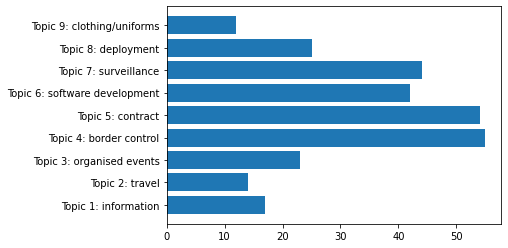

In [276]:
# docments per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
print("Document distribution")

In [233]:
def describe_doc(doc_id, plot=True):
    print("Description:")
    print(descriptions["Short description"].iloc[doc_id])

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 60
Description:
For the purpose of this contract, Maritime Analysis Tools is defined as a system that works with maritime ‘big data’ (e.g. maritime reporting systems data, information on ship ownership/management, historical movements of vessels, and relevant open source information). The system must be capable of producing information of interest for border/coast guard and law enforcement authorities by performing the following functions: (a) capturing, collecting, storing, searching, querying, visualization and updating maritime ‘big data’; (b) analysing, identifying/categorising high-risk threats, assessing maritime risks and informing policy and practice in this work area of the maritime domain; (c) performing analytical capabilities to research systematically the maritime risk environment and deliver a set of products, such as risk alerts/profiles, periodical strategic overviews, maritime area analyses and EU/regional risk maps.

Topics (ranked):


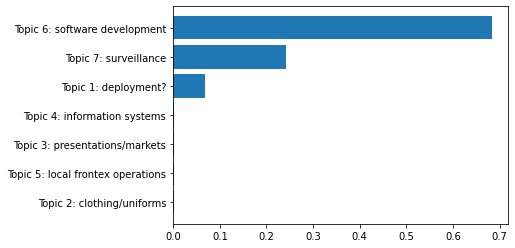

In [245]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(descriptions["Short description"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(7)

Topic: 2 - travel
Number of documents for this topic: 14

doc_id: 189
Description:
Provision of mobile office containers and associated services in Republic of North Macedonia.

Topics (ranked):
doc_id: 190
Description:
Provision of toilet containers and associated services in Republic of North Macedonia.

Topics (ranked):
doc_id: 61
Description:
The main objective of this FWC is systematic access to the services of optical satellite imagery provisioning to support the achievement of the Frontex’ operational objectives.

Topics (ranked):
doc_id: 63
Description:
Provision of fuel cards and associated services for Frontex vehicles based on no-cash operations in Montenegro, Serbia and Turkey.

Topics (ranked):
doc_id: 75
Description:
Returns by scheduled flights supported by Frontex

Topics (ranked):
doc_id: 131
Description:
Provision of fuel cards and associated services for Frontex cars operating in Bulgaria.

Topics (ranked):
doc_id: 62
Description:
Provision of fuel cards and associat

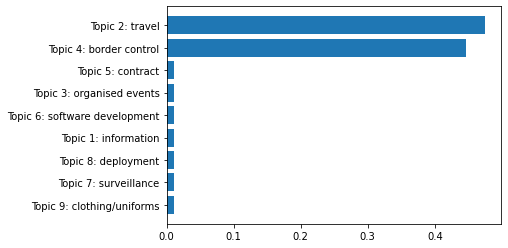

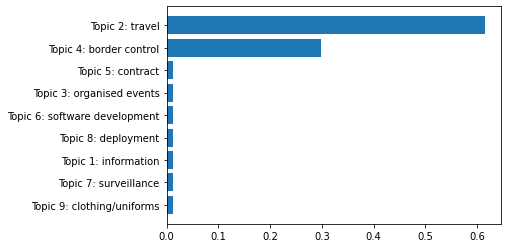

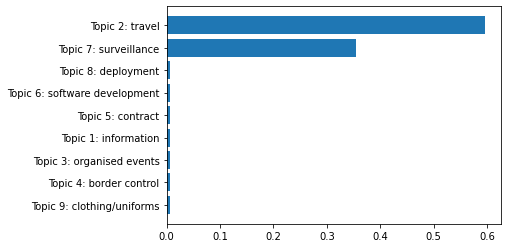

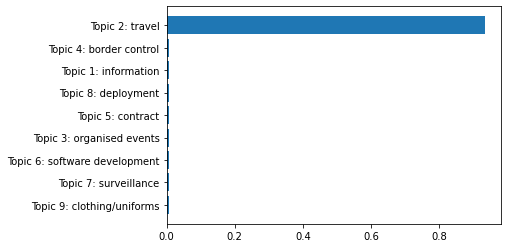

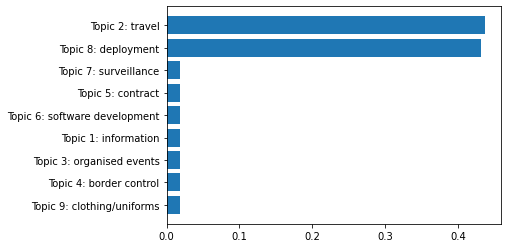

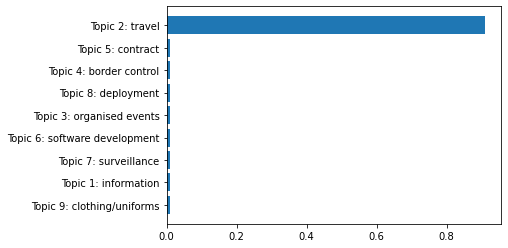

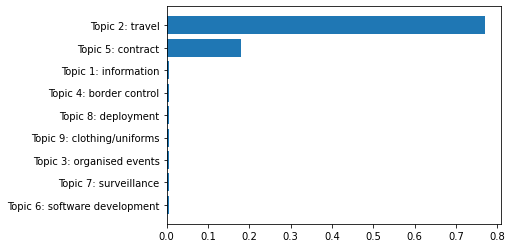

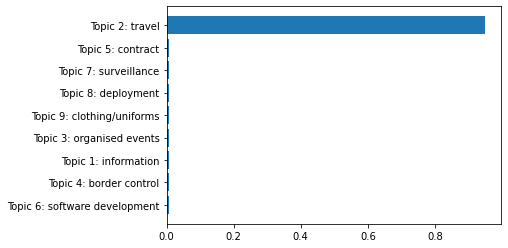

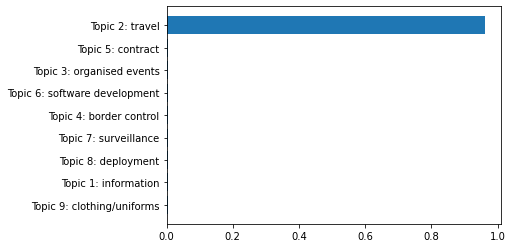

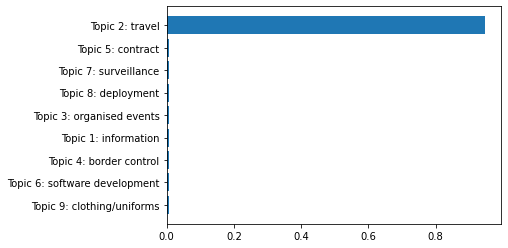

In [280]:
# For a given topic sample a random document
topic_n = 2
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=10):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)